In [1]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
import torch.nn.functional as F
from snntorch import functional as SF
import brevitas.nn as qnn 
from tqdm import tqdm
from pathlib import Path

import sys
sys.path.append('../src')
from my_network_state_quant import *
from dataloader import WisdmDatasetParser, WisdmDataset
from torch.utils.data import  DataLoader
from assistant import Assistant
from stats import LearningStats
from utils import *

In [ ]:

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = 'cuda'
print(f'Using device {device}')

In [3]:
batch_size = 512
slope = 10
# network parameters
num_inputs = 6 
num_steps = 40
net_hidden_1 = 180
net_hidden_2 = 400
net_hidden_3 = 128
num_outputs = 7
pop_outputs = num_outputs * 10
num_epochs = 200
vth_in = 1.0
vth_out = 1.0
vth_recurrent = 1.0
vth_enc_value =  1.0
vth_std =  65 
beta_in = 0.5
beta_recurrent = 0.5
beta_back = 0.6
beta_out = 0.5
encoder_dim = 25
beta_std = 55
lr = 0.002
drop_recurrent =0.15
drop_back = 0.15
drop_out = 0.15
# spiking neuron parameters
beta = 0.8  # neuron decay rate


In [4]:
DATASET_NAME = 'data_watch_subset_0_40.npz'
DATASET_SUBSET = 'custom'
SUBSET_LIST = [0, 4, 6, 8, 9, 10, 14]
PATIENCE = 10
TRAIN_FOLDER_NAME = 'Trained'
NUM_WORKERS = 8
NET_OUTPUT_DIM = 7
NET_INPUT_DIM = 6
NUM_EPOCHS = 200
SEARCH_SPACE_SHUFFLE = 200

[Epoch  0/200] Training: loss =     0.18501                          accuracy = 0.95123 : 100%|██████████| 43/43 [00:23<00:00,  1.80it/s]
[Epoch  0/200] Validation: loss =     0.23596                          accuracy = 0.94098 : 100%|██████████| 15/15 [00:04<00:00,  3.11it/s]
  0%|          | 0/43 [00:00<?, ?it/s]/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/snntorch/_neurons/neurons.py:399: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  arg = torch.zeros_like(input_, requires_grad=True)
/home/franzhd/snntorch_network/notebook/../src/RecurrentAHPC_debug.py:125: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  base_fn = s

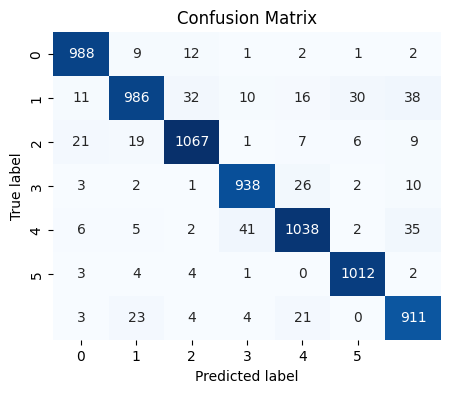

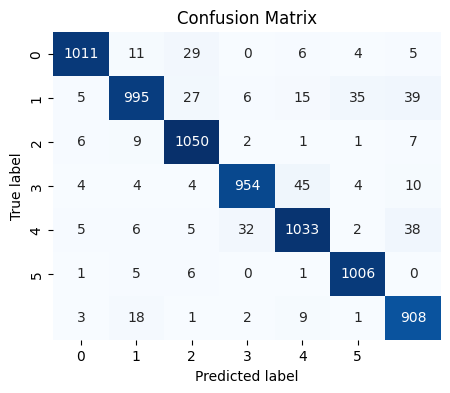

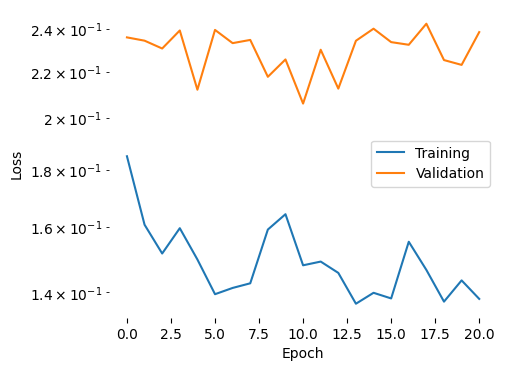

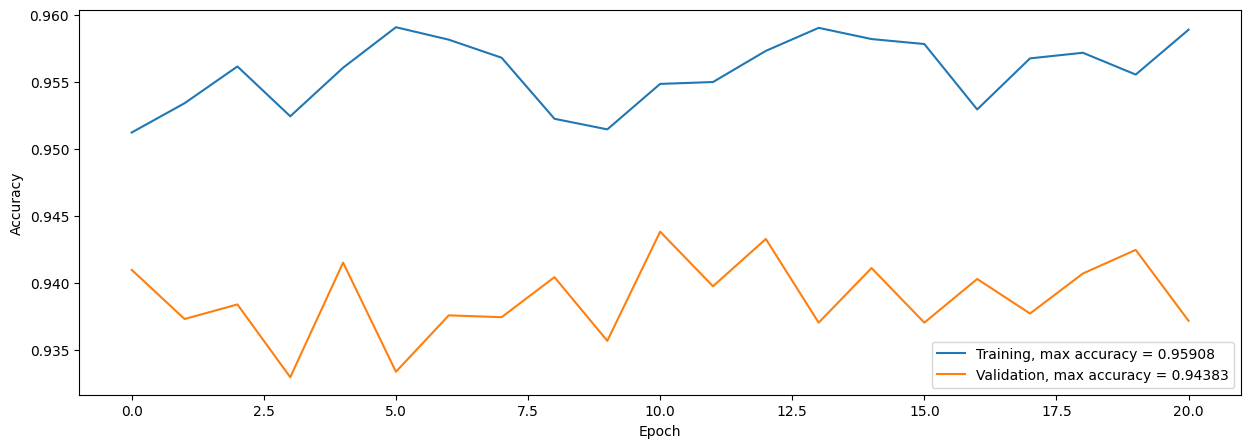

In [5]:
trained_folder = TRAIN_FOLDER_NAME
os.makedirs(trained_folder, exist_ok=True)
dataset = WisdmDatasetParser(f'{Path.home()}/snntorch_network/data/{DATASET_NAME}', norm=None, class_sublset=DATASET_SUBSET, subset_list=SUBSET_LIST)
val_set = dataset.get_validation_set()
train_set = dataset.get_training_set()

val_dataset = WisdmDataset(val_set)
train_dataset = WisdmDataset(train_set)

val_loader  = DataLoader(dataset= val_dataset, batch_size=int(batch_size), shuffle=True, num_workers=NUM_WORKERS)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device {device}')

grad = surrogate.fast_sigmoid(slope) #use slope for HPO

net_loss = regularization_loss(0.1, 0.03, 40)

net = ExInbitoryNetwork(NET_INPUT_DIM, int(net_hidden_1), int(net_hidden_2), NET_OUTPUT_DIM, grad,vth_back=1.0,
                    vth_in=vth_in, vth_recurrent=vth_recurrent, vth_out=vth_out,
                    beta_in=beta_in, beta_recurrent=beta_recurrent, beta_back=beta_back, beta_out=beta_out,
                    # encoder_dim=int(encoder_dim),
                    # vth_enc_value=vth_enc_value, vth_std=vth_std, beta_std=beta_std,
                    drop_recurrent=drop_recurrent, drop_back=drop_back, drop_out=drop_out,
                    time_dim=2, layer_loss=net_loss, state_quant=False).to(device)
net.from_npz(f"{Path.home()}/snntorch_network/nni_experiments/Inibitory_lif_no_encoder/results/hjulef4s/trials/RHEsE/Trained/network_best.npz")
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)

loss_fn = SF.loss.ce_count_loss()

stats = LearningStats()
assistant = Assistant(net, loss_fn, optimizer, stats, classifier=True, scheduler=scheduler, lam=1.0)


count = 0
for epoch in range(NUM_EPOCHS):
    labels = []
    outputs = []
    # if epoch % 20 == 0:
    #     assistant.reduce_lr()
    if count < PATIENCE:
        count = count+1
        tqdm_dataloader = tqdm(train_loader)
        for _, batch in enumerate(tqdm_dataloader): # training loop
            input, label = batch
            
            output = assistant.train(input, label)
            tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{NUM_EPOCHS}] Training: {stats.training}')

        tqdm_dataloader = tqdm(val_loader)
        for _, batch in enumerate(tqdm_dataloader): #eval loop
            input, label = batch
            output = assistant.valid(input, label)
            tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{NUM_EPOCHS}] Validation: {stats.validation}')
        
            if len(outputs) == 0:
                outputs = output.to('cpu').detach()
                labels = label.to('cpu').detach()
            else:
                outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
                labels = torch.cat((labels, label.to('cpu').detach()))

        stats.update()

        if stats.validation.best_accuracy:
            count = 0
            _, predictions = outputs.sum(dim=0).max(1)
            gen_confusion_matrix(predictions,labels, f'./{trained_folder}/')
            net.save_to_npz(f'./{trained_folder}/network_best.npz')
            stats.plot(figsize=(15, 5),path=f'./{trained_folder}/')
            stats.save( f'./{trained_folder}/')
            del predictions

        del outputs
        del labels
        
        torch.cuda.empty_cache()
stats.plot(figsize=(15, 5),path=f'./{trained_folder}/')
stats.save( f'./{trained_folder}/')


In [6]:
print(net.linear1.weight)
print(net.linear1.weight.dtype)
print(net.linear1.quant_weight_scale()) 
print(net.linear1.quant_weight_zero_point())

Parameter containing:
tensor([[ 1.0836e-02, -1.4508e-01, -4.3903e-03, -1.6493e-02,  2.8435e-02,
         -1.2669e-01],
        [-5.5564e-02, -1.4822e-01,  2.3166e-02, -1.4180e-01, -9.6816e-02,
          3.9519e-03],
        [-1.2974e-02,  3.6019e-02,  1.3351e-01,  9.4253e-01, -4.5805e-01,
         -1.1897e+00],
        [-1.3483e-02,  1.4447e-01, -9.8600e-02, -3.6441e-03,  9.8959e-02,
          2.7560e-01],
        [-7.2928e-02, -2.3219e-02,  1.2289e-02,  5.1489e-02, -1.5102e-01,
          3.4841e-01],
        [ 1.3350e-01, -5.3385e-02,  2.9745e-02,  4.3741e-02,  1.1870e+00,
         -1.2733e-01],
        [-2.0006e-02,  2.7704e-03,  8.9361e-02, -8.1906e-01,  1.7262e-02,
         -6.3245e-02],
        [-3.5972e-03,  1.0137e-01, -1.2084e-01, -6.4359e-02,  6.2457e-01,
          3.1347e-01],
        [-4.9576e-02, -6.8663e-02,  2.6558e-02,  1.3018e-01,  6.6403e-03,
          2.7263e-01],
        [ 7.6555e-02,  7.6738e-02, -1.4192e-01, -7.5162e-02,  2.1463e-01,
         -8.8083e-03],
        

In [7]:
print(net.linear2.weight)
print(net.linear2.weight.dtype)

Parameter containing:
tensor([[-0.2028, -0.0066,  0.1141,  ..., -0.2841,  0.0620, -0.1102],
        [-0.2429, -0.3274,  0.1569,  ...,  0.1006, -0.2584,  0.1563],
        [ 0.2895, -0.0780,  0.1217,  ..., -0.4008, -0.0416,  0.0229],
        ...,
        [-0.1330, -0.1121, -0.0439,  ...,  0.1473, -0.0243, -0.1506],
        [-0.0319,  0.0253,  0.1042,  ..., -0.1814,  0.0032, -0.0870],
        [-0.2430, -0.0983, -0.0260,  ...,  0.0152, -0.0598, -0.0269]],
       device='cuda:0', requires_grad=True)
torch.float32


In [8]:
print(net.linear2.quant_weight().value)

tensor([[-0.2031, -0.0000,  0.1094,  ..., -0.2812,  0.0625, -0.1094],
        [-0.2500, -0.3281,  0.1562,  ...,  0.0938, -0.2656,  0.1562],
        [ 0.2969, -0.0781,  0.1250,  ..., -0.4062, -0.0469,  0.0156],
        ...,
        [-0.1406, -0.1094, -0.0469,  ...,  0.1406, -0.0312, -0.1562],
        [-0.0312,  0.0312,  0.1094,  ..., -0.1875,  0.0000, -0.0938],
        [-0.2500, -0.0938, -0.0312,  ...,  0.0156, -0.0625, -0.0312]],
       device='cuda:0', grad_fn=<MulBackward0>)


In [9]:
print(net.leaky2.beta.data)
print(net.leaky2.threshold.data)
print(net.leaky1.beta.data)
print(net.leaky1.threshold.data)
print(net.recurrent.beta.data)
print(net.recurrent.threshold.data)

tensor(1.0035, device='cuda:0')
tensor(1.6362, device='cuda:0')
tensor(0.2048, device='cuda:0')
tensor(1.7894, device='cuda:0')
tensor(0.8558, device='cuda:0')
tensor(0.7430, device='cuda:0')


In [10]:
net.from_npz(f'./{trained_folder}/network_best.npz')
net.to(device)


ExInbitoryNetwork(
  (linear1): QuantLinear(
    in_features=6, out_features=180, bias=False
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (extra_tracked_params_list): ModuleList(
              (0-3): 4 x _ViewCatParameterWrapper(
                (view_s

In [11]:
print(net.linear1.weight)
print(net.linear1.weight.dtype)
print(net.linear1.quant_weight_scale()) 
print(net.linear1.quant_weight_zero_point())

Parameter containing:
tensor([[ 0.0146, -0.1299, -0.0040, -0.0144,  0.0447, -0.1736],
        [-0.0566, -0.1482,  0.0164, -0.1580, -0.0779,  0.0033],
        [ 0.0087,  0.0498,  0.1319,  0.8991, -0.4315, -1.2212],
        [ 0.0072,  0.1477, -0.1025,  0.0534,  0.0937,  0.2646],
        [-0.1082, -0.0536,  0.0490,  0.0471, -0.0881,  0.3621],
        [ 0.1302, -0.0500,  0.0263,  0.0438,  1.2223, -0.0480],
        [-0.0133,  0.0089,  0.0706, -0.8100, -0.0307, -0.0329],
        [-0.0322,  0.1080, -0.1466, -0.0669,  0.6764,  0.3475],
        [-0.0778, -0.0849,  0.0369,  0.0665,  0.0534,  0.2998],
        [ 0.0713,  0.0553, -0.1419, -0.0698,  0.2443, -0.0445],
        [-0.0524, -0.0270, -0.0518, -0.4800,  0.0424, -0.4502],
        [ 0.0619,  0.0201, -0.0649,  0.1346,  0.1501, -0.4761],
        [-0.0438,  0.0701,  0.0223,  0.1318,  0.1579,  0.0728],
        [ 0.0268, -0.0233, -0.0744, -0.0261,  0.3458, -0.0034],
        [-0.0858,  0.0992,  0.0690, -0.2828,  0.1073,  0.4090],
        [-0.1113, 

In [12]:
print(net.linear2.quant_weight().value)

tensor([[-0.1406, -0.0469,  0.0625,  ..., -0.2188,  0.0625, -0.1094],
        [-0.2031, -0.3125,  0.1250,  ...,  0.0938, -0.2500,  0.1719],
        [ 0.2969, -0.1094,  0.1250,  ..., -0.3281, -0.0156,  0.0625],
        ...,
        [-0.1094, -0.1562, -0.0469,  ...,  0.1719, -0.0781, -0.1719],
        [-0.0469,  0.0469,  0.1562,  ..., -0.1719,  0.0000, -0.1094],
        [-0.2812, -0.1094, -0.0156,  ...,  0.0469, -0.0312, -0.0625]],
       device='cuda:0', grad_fn=<MulBackward0>)


In [13]:
labels = []
outputs = []

tqdm_dataloader = tqdm(val_loader)
for _, batch in enumerate(tqdm_dataloader): #eval loop
    input, label = batch
    output = assistant.valid(input, label)
    tqdm_dataloader.set_description(f'\r Validation: {stats.validation}')

    if len(outputs) == 0:
        outputs = output.to('cpu').detach()
        labels = label.to('cpu').detach()
    else:
        outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
        labels = torch.cat((labels, label.to('cpu').detach()))

del labels
del outputs

torch.cuda.empty_cache()


 Validation: loss =     0.20416 (min =     0.20607)     accuracy = 0.94383 (max = 0.94383) : 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]
